In [64]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from typing import Literal
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

from langchain_text_splitters import MarkdownHeaderTextSplitter

from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
import pprint

from dotenv import load_dotenv
load_dotenv()
from langchain_chroma import Chroma

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents.base import Document
import os


**Cached Retriever and LLM**

In [65]:
# TODO: update vectorstore
def get_retriever(collection_name, md_path=None):
    
    DB_PATH = "../chroma_db"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

    if os.path.isdir(DB_PATH):
        vectorstore = Chroma(
            persist_directory=DB_PATH,
            embedding_function=embeddings,
            collection_name=collection_name
        )
    else:
        with open(md_path, "r") as f:
            text = f.read()
        headers = [
            ('#', "Book"),
            ('##', 'Part'),
            ('###', 'Title'),
            ('####', 'Chapter'),
            ('#####', 'Section')
        ]
        splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers,
                                            strip_headers=False,)
        md_splits = splitter.split_text(text)


        vectorstore = Chroma.from_documents(
            documents=md_splits,
            collection_name=collection_name,
            embedding=embeddings,
            persist_directory=DB_PATH
        )

    retriever = vectorstore.as_retriever()
    return retriever  # retriever = get_retriever("CCC", md_path= "../docs/ประมวลกฎหมายแพ่งและพาณิชย์ (ฉบับอัพเดทล่าสุด).md")

In [66]:
def get_llm():
    return ChatOpenAI(model="gpt-4o")

In [67]:
retriever = get_retriever("CCC", md_path= "../docs/ประมวลกฎหมายแพ่งและพาณิชย์ (ฉบับอัพเดทล่าสุด).md")

**Edges**

In [68]:
def route_query(state) -> Literal["similariy_search", "metadata_search"]:
    question = state['question']

    class RouteQuery(BaseModel):
        tool: Literal["similarity_search", "metadata_search"] = Field(
        description="Given a user question, choose to route it to similarity search or metadata search.")

    llm = get_llm().with_structured_output(RouteQuery)

    system = """You are an expert at routing a user question about Thai laws to a similarity search tool or a metadata search tool.
    If the user names a specific number of the following: บรรพ ส่วน ลักษณะ หมวด มาตรา, route it to a metadata search tool. Otherwise, route it to
    a similarity search tool.
    """
    routing_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "{question}")]
    )

    chain = routing_prompt | llm
    tool = chain.invoke({"question": question}).tool
    
    return tool

In [69]:
def pre_generate(state) -> Literal["transform_query", "generate"]:
    filtered = state["documents"]
    if not filtered:
        return "transform_query"
    else:
        return "generate"

def grade_answer(state) -> Literal["yes", "no"]:
    question = state["question"]
    answer = state["generation"]

    class GradeAnswer(BaseModel):
        binary_score: Literal["yes", "no"] = Field(description="Answer addresses the question, 'yes' or 'no'")
    llm = get_llm().with_structured_output(GradeAnswer)

    system = """You are a grader assessing whether an answer addresses / resolves a question about Thai laws.\n
    If the answer resolves the question, answer 'yes'. Otherwise, answer 'no'.
    """
    grading_prompt = ChatPromptTemplate.from_messages(
        [("system", system),
         ("human", "User question:\n\n{question}\n\nAnswer: {generation}")]
    )
    chain = grading_prompt | llm

    score = chain.invoke({
        "question": question,
        "generation": answer
    }).binary_score
    return score

**Nodes**

In [70]:
def grade_documents(state):
    class GradeDocuments(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm = get_llm().with_structured_output(GradeDocuments)

    system = """You are a grader assessing whether a retrieved document is relevant to a user question.
    If the document contains keyword(s) or semantic meaning related to the user question, answer 'yes'. Otherwise, answer 'no'.
    """
    grading_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document:\n\n{document}\n\nUser question: {question}")
        ]
    )
    retrieval_grader = grading_prompt | llm
    question = state["question"]
    documents = state["documents"]

    filtered = []
    for doc in documents:
        score = retrieval_grader.invoke({
            "question": question,
            "document": doc.page_content
        })

        if score.binary_score == "yes":
            filtered.append(doc)
        else:
            continue
    return {"documents": filtered, "question": question}


In [71]:
def transform_query(state):
    llm = get_llm()

    system = """You are a Thai legal question rewriter that converts an input to a better version that is optimized\n
    for Thai legal code retrieval. Look at the question and reason about the underlying semantic intent / meaning."""
    rewriting_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Initial question\n\n{question}\n\n\Formulate an improved one.")
    ])
    chain = rewriting_prompt | llm | StrOutputParser()
    res = chain.invoke({
        "question": state['question']
    })
    return {
        "documents": state['documents'],
        "question": res
    }

<>:8: SyntaxWarning: invalid escape sequence '\F'
<>:8: SyntaxWarning: invalid escape sequence '\F'
/var/folders/cc/rnt3w6p15_9bhmg17qtpnjlw0000gn/T/ipykernel_74916/860843229.py:8: SyntaxWarning: invalid escape sequence '\F'
  ("human", "Initial question\n\n{question}\n\n\Formulate an improved one.")


In [72]:
def generate(state):
    question = state['question']
    documents = state['documents']

    llm = get_llm()
    template = """You are an assistant for question-answering tasks about Thai laws.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know. Keep the answer concise but comprehensive.
    If it is a procedural question, structure the answer as a numbered list.
    Keep a friendly, semi-formal tone, refer to yourself as 'ทนายแตน' and use คะ/ค่ะ when neccessary. 
    \nQuestion: {question}
    \nContext: {context} 
    \nAnswer:"""

    prompt = ChatPromptTemplate.from_template(template=template,
                               input_variable=['context', 'question'])


    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    chain = prompt | llm | StrOutputParser()
    generation = chain.invoke({
        "context": formatted_docs,
        "question": question
    })

    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [73]:
# Tools

def similarity_search(state):
    retriever = get_retriever("CCC")
    question = state["question"]

    return {"documents": retriever.invoke(question, k=3), "question": question}

def metadata_search(state): 
    question = state["question"]
    class MetadataQuery(BaseModel):
        Section: str | None= Field(description="มาตรา")
    llm = get_llm().with_structured_output(MetadataQuery)

    system = """You are a Thai legal metadata search tool that uses\n
    a user input to generate a metadata filter on มาตรา (Section).\n
    
    Example query: มาตราที่ 5 เกี่ยวกับอะไร 
    Expected output: {{"Section": "มาตรา 5"}}
    """
    filtering_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "User input:\n\n{question}\n\nFormulate a dictionary.")
    ])
    chain = filtering_prompt | llm
    outputs = chain.invoke({
        "question": question
    })

    retriever = get_retriever("CCC")
    documents = retriever.invoke(question, filter=outputs.dict())

    return {"documents": documents, "question": question}
    

**Graph**

In [74]:
class GraphState(TypedDict):
    question:str
    generation:str
    documents: list[Document]

In [75]:
workflow = StateGraph(GraphState)

workflow.add_node("similarity_search", similarity_search)
workflow.add_node("metadata_search", metadata_search)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)

workflow.add_conditional_edges(
    START,
    route_query,
    {
        "similarity_search": "similarity_search",
        "metadata_search": "metadata_search",
    }

)
workflow.add_conditional_edges("metadata_search", pre_generate, 
                               {"transform_query": "transform_query",
                                "generate": "generate"})
workflow.add_conditional_edges("similarity_search", pre_generate,
                               {"transform_query": "transform_query",
                                "generate": "generate"})
workflow.add_edge("transform_query", "similarity_search")
workflow.add_conditional_edges(
    "generate",
    grade_answer,
    {
        "yes": END,
        "no": "transform_query"
    }
)

app = workflow.compile()


<unknown>:8: SyntaxWarning: invalid escape sequence '\F'


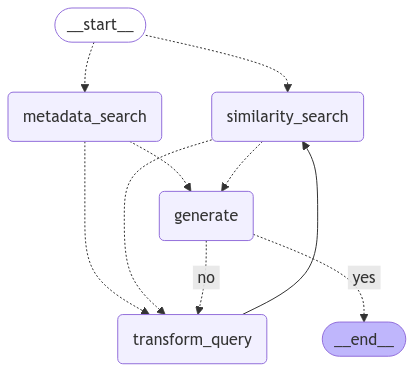

In [76]:
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [77]:
def call(question):

    for output in app.stream({"question": question}):
        for k,v in output.items():
            pprint.pprint(f"Output from node '{k}'")
            pprint.pprint(v, indent=2, width=80, depth=None)
        pprint.pprint("---")

In [78]:
app.invoke({"question": "ถ้าผู้เช่าห้องทําห้องเสียหาย สามารถเอาผิดได้อย่างไร"})

{'question': 'ถ้าผู้เช่าห้องทําห้องเสียหาย สามารถเอาผิดได้อย่างไร',
 'generation': 'ถ้าผู้เช่าห้องทำห้องเสียหาย เจ้าของห้องสามารถดำเนินการตามกฎหมายได้ตามขั้นตอนดังนี้ค่ะ:\n\n1. **แจ้งเตือนผู้เช่า**: หากทราบว่าผู้เช่าได้ทำให้ทรัพย์สินเสียหาย ควรแจ้งเตือนผู้เช่าให้ทราบถึงความเสียหายและขอให้ซ่อมแซมหรือชดใช้ค่าเสียหายตามที่เหมาะสมค่ะ\n\n2. **ตรวจสอบสัญญาเช่า**: ตรวจสอบสัญญาเช่าเพื่อดูว่ามีเงื่อนไขหรือข้อกำหนดที่เกี่ยวข้องกับความเสียหายหรือการซ่อมแซมอย่างไรบ้าง ถ้ามีระบุในสัญญา ผู้ให้เช่าสามารถใช้ประโยชน์จากข้อตกลงนั้นได้ค่ะ\n\n3. **เรียกร้องค่าเสียหาย**: หากผู้เช่าไม่ยอมซ่อมแซมหรือชดใช้ค่าเสียหาย ผู้ให้เช่าสามารถเรียกร้องค่าเสียหายได้ตามมาตรา 557 โดยการฟ้องร้องต่อศาลค่ะ\n\n4. **เก็บหลักฐาน**: ควรเก็บหลักฐานที่เกี่ยวข้อง เช่น ภาพถ่ายของความเสียหาย ใบเสนอราคาการซ่อมแซม เอกสารสัญญาเช่า และการสนทนากับผู้เช่าเพื่อใช้เป็นหลักฐานในกรณีที่ต้องดำเนินการทางกฎหมายค่ะ\n\nทนายแตนหวังว่าข้อมูลนี้จะช่วยให้คุณเข้าใจขั้นตอนในการดำเนินการได้มากขึ้นนะคะ 😊',
 'documents': [Document(metadata={'Book': 'บรรพ 3 เ